
--- Simplified Flood Risk Weight Extractor ---

Loading data from japan_flood_data_final.csv...
Loaded data with 33065 rows and 53 columns
Extracting simple numerical features...
Extracted 45 clean numerical features.
Training model to derive risk weights...


<ipython-input-12-844fe289020c>:27: DtypeWarning: Columns (4,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='utf-8')



Derived weights for flood risk factors:
elevation: 0.185
hand: 0.016
upstream: 0.760
flow_conv: 0.000
river_width: 0.039

--- Process Complete ---
All outputs saved to ml_flood_outputs
To use the new risk function, replace the existing calculate_flood_risk function with calculate_flood_risk_ml


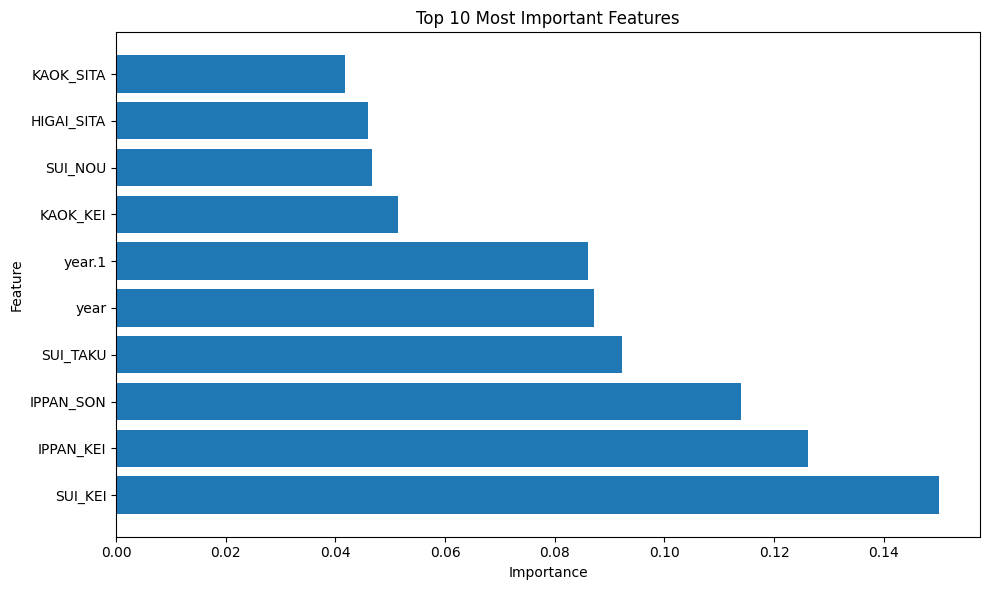

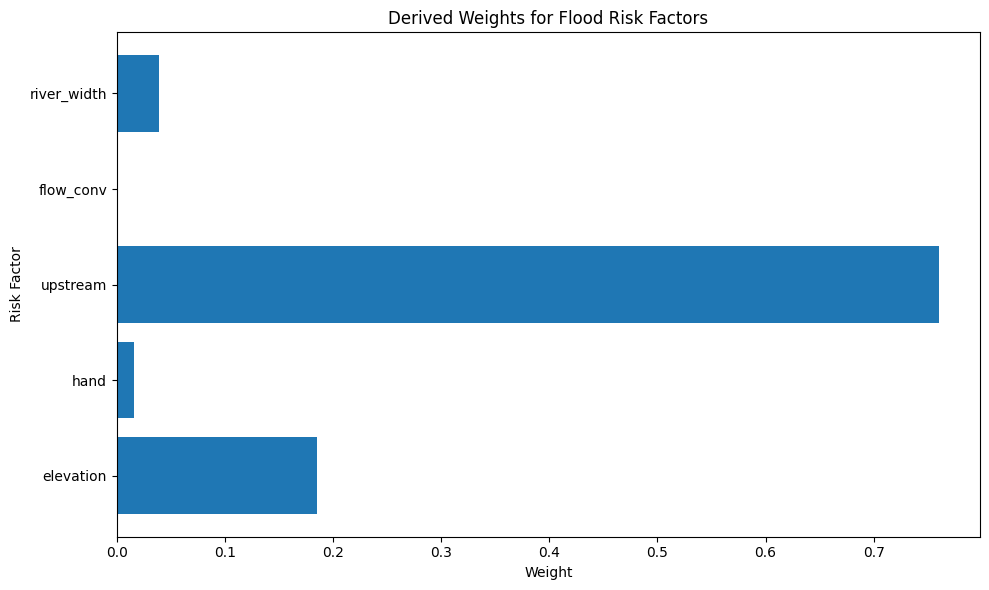

In [12]:
"""
Simplified Flood Risk Weight Extractor

This script analyzes historical Japanese flood data to extract optimal weights
for flood risk factors, while avoiding complex feature engineering steps
that might cause type errors.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Create output directory
OUTPUT_DIR = 'ml_flood_outputs'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def load_data(file_path):
    """Load flood data and perform basic preprocessing."""
    print(f"Loading data from {file_path}...")
    # Try different encodings
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='cp932')
    except Exception as e:
        print(f"Error reading CSV: {e}")
        # Last resort - try with error handling
        df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')

    print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
    return df


def extract_simple_features(df):
    """Extract simple numerical features that don't require string operations."""
    print("Extracting simple numerical features...")

    # Start with only numerical columns to avoid type issues
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Create a clean DataFrame with only numeric values
    clean_df = df[numeric_cols].copy()

    # Fill missing values with appropriate defaults
    for col in clean_df.columns:
        if clean_df[col].isna().sum() > 0:
            if 'KEI' in col or 'NOU' in col or 'GKEI' in col:
                # For damage-related columns, use 0
                clean_df[col] = clean_df[col].fillna(0)
            else:
                # For other columns, use median
                clean_df[col] = clean_df[col].fillna(clean_df[col].median())

    # Target variable: flood area or damage
    if 'flood_area_km2' in clean_df.columns:
        # Log transform to handle skewness
        clean_df['flood_area_log'] = np.log1p(clean_df['flood_area_km2'].clip(lower=0.01))
    else:
        print("Warning: 'flood_area_km2' not found in data.")
        clean_df['flood_area_log'] = 0

    # Create categorical features from numerical ranges
    # River size category based on SUI_KEI (river basin area)
    if 'SUI_KEI' in clean_df.columns:
        bins = [0, 1000, 10000, 100000, float('inf')]
        labels = [1, 2, 3, 4]
        clean_df['river_size_category'] = pd.cut(clean_df['SUI_KEI'], bins=bins, labels=labels)
        clean_df['river_size_category'] = clean_df['river_size_category'].astype(float)

    # Damage intensity categories
    if 'HIGAI_GKEI' in clean_df.columns:
        bins = [0, 1000, 10000, 50000, float('inf')]
        labels = [1, 2, 3, 4]
        clean_df['damage_category'] = pd.cut(clean_df['HIGAI_GKEI'], bins=bins, labels=labels)
        clean_df['damage_category'] = clean_df['damage_category'].astype(float)

    print(f"Extracted {clean_df.shape[1]} clean numerical features.")
    return clean_df

def map_features_to_risk_factors(feature_importance):
    """Map ML features to risk factors used in the GeoTIFF-based model.
    A feature can map to multiple risk factors."""

    # Define risk factors from the original model
    risk_factors = ['elevation', 'hand', 'upstream', 'flow_conv', 'river_width']

    # Create mappings based on the specific column names from the metadata
    # Each feature can map to multiple factors (use a list of factors for each feature)
    feature_to_factors = {}

    for feature in feature_importance['Feature']:
        feature_lower = feature.lower()
        factors = []

        # Elevation-related features
        if any(term in feature_lower for term in ['jsit', 'jue', 'kaok_sita', 'kaok_ue']):
            factors.append('elevation')

        # HAND-related features - Height Above Nearest Drainage
        if any(term in feature_lower for term in ['jhau', 'kaok_hau', 'kaok_j']):
            factors.append('hand')

        # Upstream area features
        if any(term in feature_lower for term in ['sui_kei', 'sui_nou', 'sui_taku', 'suikei', 'area']):
            factors.append('upstream')

        # Flow convergence features
        if any(term in feature_lower for term in ['jzen', 'jryu', 'kasen', 'flow', 'kasen_1ji']):
            factors.append('flow_conv')

        # River width features
        if any(term in feature_lower for term in ['jzka', 'jhan', 'river_size', 'kaok_zen', 'kaok_han']):
            factors.append('river_width')

        # Only add to the mapping if the feature maps to at least one factor
        if factors:
            feature_to_factors[feature] = factors

    return feature_to_factors

def calculate_factor_weights(feature_importance, feature_to_factors):
    """Calculate weights for each risk factor based on feature importance.
    Features can contribute to multiple risk factors."""

    # Initialize factor importance sums
    factor_importance = {
        'elevation': 0,
        'hand': 0,
        'upstream': 0,
        'flow_conv': 0,
        'river_width': 0
    }

    # Count how many features contribute to each factor (for normalization)
    for feature, importance in zip(feature_importance['Feature'], feature_importance['Importance']):
        if feature in feature_to_factors:
            factors = feature_to_factors[feature]
            # Distribute feature importance equally among all factors it maps to
            importance_per_factor = importance / len(factors)

            # Add to each mapped factor
            for factor in factors:
                factor_importance[factor] += importance_per_factor

    # Normalize to get weights summing to 1
    total_importance = sum(factor_importance.values())
    if total_importance > 0:  # Avoid division by zero
        weights = {factor: (importance / total_importance) for factor, importance in factor_importance.items()}
    else:
        # Default to equal weights if no importance was calculated
        weights = {factor: 0.2 for factor in factor_importance.keys()}

    return weights

def derive_risk_weights(df, target_col='flood_area_log'):
    """Train a model and derive weights for flood risk factors."""
    print("Training model to derive risk weights...")

    # Select features (all columns except the target)
    features = [col for col in df.columns if col != target_col and col != 'flood_area_km2']

    # Prepare data
    X = df[features].copy()
    y = df[target_col].copy()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a simple Random Forest model
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Calculate feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Save feature importance
    feature_importance.to_csv(os.path.join(OUTPUT_DIR, 'feature_importance.csv'), index=False)

    # Map features to risk factors (now features can map to multiple factors)
    feature_to_factors = map_features_to_risk_factors(feature_importance)

    # Calculate weights for each risk factor
    weights = calculate_factor_weights(feature_importance, feature_to_factors)

    # Print and save weights
    print("\nDerived weights for flood risk factors:")
    for factor, weight in weights.items():
        print(f"{factor}: {weight:.3f}")

    weights_df = pd.DataFrame({
        'Factor': weights.keys(),
        'Weight': weights.values()
    })
    weights_df.to_csv(os.path.join(OUTPUT_DIR, 'risk_weights.csv'), index=False)

    # Save feature mappings for analysis
    mappings = []
    for feature, factors in feature_to_factors.items():
        for factor in factors:
            mappings.append({
                'Feature': feature,
                'RiskFactor': factor
            })

    if mappings:
        mappings_df = pd.DataFrame(mappings)
        mappings_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_to_risk_mappings.csv'), index=False)

    # Plot top 10 feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

    # Also save a plot showing the derived weights
    plt.figure(figsize=(10, 6))
    plt.barh(list(weights.keys()), list(weights.values()))
    plt.xlabel('Weight')
    plt.ylabel('Risk Factor')
    plt.title('Derived Weights for Flood Risk Factors')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'risk_weights.png'))

    return weights

def main():
    """Main function to run the weight extraction process."""
    print("\n--- Simplified Flood Risk Weight Extractor ---\n")

    # Load data
    df = load_data('japan_flood_data_final.csv')

    # Extract simple features (avoiding string operations that might cause issues)
    clean_df = extract_simple_features(df)

    # Derive risk weights
    weights = derive_risk_weights(clean_df)

    print("\n--- Process Complete ---")
    print(f"All outputs saved to {OUTPUT_DIR}")
    print("To use the new risk function, replace the existing calculate_flood_risk function with calculate_flood_risk_ml")

if __name__ == "__main__":
    main()